# Quickstart: Collisional Ionization Equilibrium

Example of using `pism` to solve for collisional ionization equilibrium (CIE) for a hydrogen-helium mixture and plot the ionization states as a function of temperature.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
from matplotlib import pyplot as plt
import sympy as sp

## Simple processes
A simple process is defined by a single reaction, with a specified rate.

Let's inspect the structure of a single process, the gas-phase recombination of H+: `H+ + e- -> H + hν` 

In [2]:
from pism.processes import CollisionalIonization, GasPhaseRecombination

process = GasPhaseRecombination("H+")
print(f"Name: {process.name}")
print(f"Heating rate coefficient: {process.heat_rate_coefficient}")
print(f"Heating rate per cm^-3: {process.heat}"),
print(f"Rate coefficient: {process.rate_coefficient}")
print(f"Recombination rate per cm^-3: {process.rate}")
print(f"e- conservation equation: {process.network["e-"].rhs}")

Name: Gas-phase recombination of H+
Heating rate coefficient: -1.46719838641439e-26*sqrt(T)/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Heating rate per cm^-3: -1.46719838641439e-26*sqrt(T)*n_H+*n_e-/((0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Rate coefficient: 1.41621465870114e-10/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
Recombination rate per cm^-3: 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)
e- conservation equation: -1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)


Note that all symbolic representations assume CGS units as is standard in ISM physics.

## Composing processes
Now let's define our full network as a sum of simple processes

In [3]:
processes = [CollisionalIonization(s) for s in ("H", "He", "He+")] + [GasPhaseRecombination(i) for i in ("H+", "He+", "He++")]
system = sum(processes)

Summed processes keep track of all subprocesses, e.g. the total net heating rate is:

Summing processes also sums all chemical and gas/dust cooling/heating rates. 

## Solving ionization equilibrium

We would like to solve for ionization equilibrium given a temperature $T$, overall H number density $n_{\rm H,tot}$, and helium mass fraction $Y$.  We define a dictionary of those input quantities and also one for the initial guesses of the number densities of the species in the reduced network.

In [ ]:
Tgrid = np.logspace(3,6,10**6)
ngrid = np.ones_like(Tgrid) * 100

knowns = {"T": Tgrid, "n_Htot": ngrid}

subsystem = system.network.reduced_system(knowns)#,time_dependent=["heat"])  #,time_dependent=["heat", "e-"])
print(subsystem["H"].rhs.subs)
#[s.rhs.free_symbols for k, s in subsystem.items()]
from pism.symbols import n_
subsystem["H+"].subs(n_("e-"), n_("H+"))

Eq(0, -5.85e-11*sqrt(T)*n_H*(n_H+ + n_He+ + 2*n_He++)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252))
<bound method Basic.subs of -5.85e-11*sqrt(T)*n_H*(Y*n_Htot/(2*(1 - Y)) - n_H - 2*n_He + n_He+ - 2*n_He+ + n_Htot)*exp(-157809.1/T)/(sqrt(10)*sqrt(T)/1000 + 1) + 1.41621465870114e-10*n_H+*n_e-/(sqrt(T)*(0.00119216696847702*sqrt(T) + 1.0)**1.748*(0.563615123664978*sqrt(T) + 1.0)**0.252)>


0

Note that by default, the solver only directly solves for $n_{\rm H}$, $n_{\rm He}$ and $n_{\rm He+}$ because $n_{\rm H+}$, $n_{\rm He++}$, and $n_{\rm e-}$ are eliminated by conservation equations. So we only need initial guesses for those 3 quantities. By default the solver takes abundances $x_i = n_i / n_{\rm H,tot}$ as inputs and outputs.

In [5]:
guesses = {
    "H": 0.5*np.ones_like(Tgrid),
    "He": 1e-5*np.ones_like(Tgrid),
    "He+": 1e-5*np.ones_like(Tgrid)
}
sol = system.steadystate(knowns, guesses,tol=1e-3)
print(sol)

TypeError: EquationSystem.solve() takes from 3 to 4 positional arguments but 10 were given

(0.0001, 3)

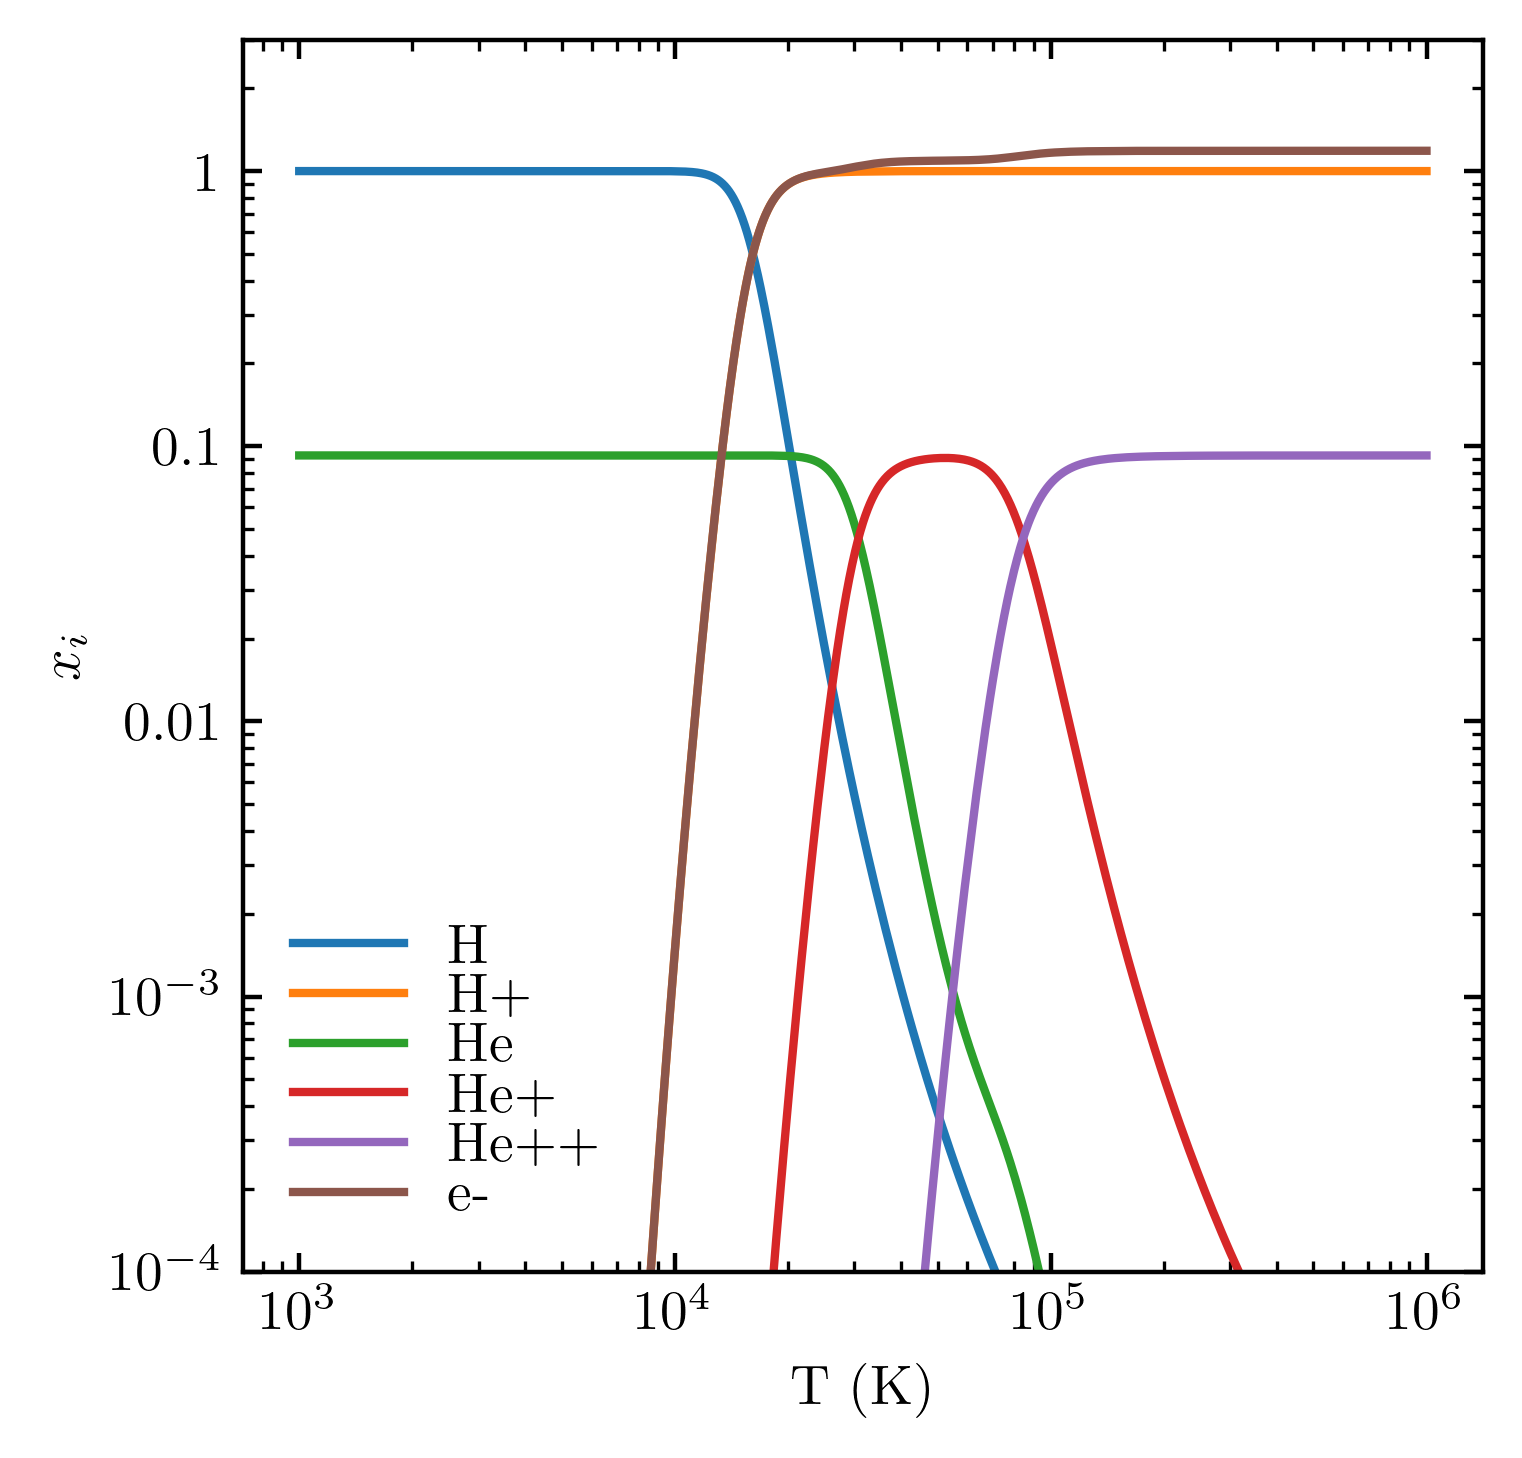

In [ ]:
for i, xi in sorted(sol.items()):
    plt.loglog(Tgrid, xi, label=i)
plt.legend(labelspacing=0)
plt.ylabel("$x_i$")
plt.xlabel("T (K)")
plt.ylim(1e-4,3)